In [4]:
import torch
x = torch.rand(5, 3)
print(x)
torch.cuda.is_available()

tensor([[0.3397, 0.1435, 0.9922],
        [0.7611, 0.7086, 0.2258],
        [0.3630, 0.5485, 0.3284],
        [0.6904, 0.3919, 0.3519],
        [0.8557, 0.7093, 0.0973]])


False

In [5]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [6]:
training_data = datasets.FashionMNIST(
    root = "Data",
    train = True,
    download = True,
    transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
    root = "Data",
    train = False,
    download = True,
    transform = ToTensor(),
)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:14<00:00, 1846697.83it/s]


Extracting Data\FashionMNIST\raw\train-images-idx3-ubyte.gz to Data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 100547.01it/s]


Extracting Data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to Data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:03<00:00, 1422198.39it/s]


Extracting Data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to Data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting Data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to Data\FashionMNIST\raw



In [10]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.317707  [   64/60000]
loss: 2.290482  [ 6464/60000]
loss: 2.268987  [12864/60000]
loss: 2.259259  [19264/60000]
loss: 2.251084  [25664/60000]
loss: 2.229172  [32064/60000]
loss: 2.226770  [38464/60000]
loss: 2.194573  [44864/60000]
loss: 2.187089  [51264/60000]
loss: 2.156085  [57664/60000]
Test Error: 
 Accuracy: 51.5%, Avg loss: 2.147209 

Epoch 2
-------------------------------
loss: 2.164017  [   64/60000]
loss: 2.141977  [ 6464/60000]
loss: 2.079266  [12864/60000]
loss: 2.093369  [19264/60000]
loss: 2.044968  [25664/60000]
loss: 1.991711  [32064/60000]
loss: 2.008234  [38464/60000]
loss: 1.923738  [44864/60000]
loss: 1.930663  [51264/60000]
loss: 1.854839  [57664/60000]
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.849913 

Epoch 3
-------------------------------
loss: 1.893987  [   64/60000]
loss: 1.854267  [ 6464/60000]
loss: 1.726807  [12864/60000]
loss: 1.767461  [19264/60000]
loss: 1.666854  [25664/60000]
loss: 1.621140  [32064/600

In [27]:
torch.save(model.state_dict(), "first_fashion_model.pth")
print("Saved PyTorch Model State to first_fasion_model.pth")

Saved PyTorch Model State to first_fasion_model.pth


In [28]:
first_fasion_model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("first_fashion_model.pth"))

<All keys matched successfully>

In [22]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


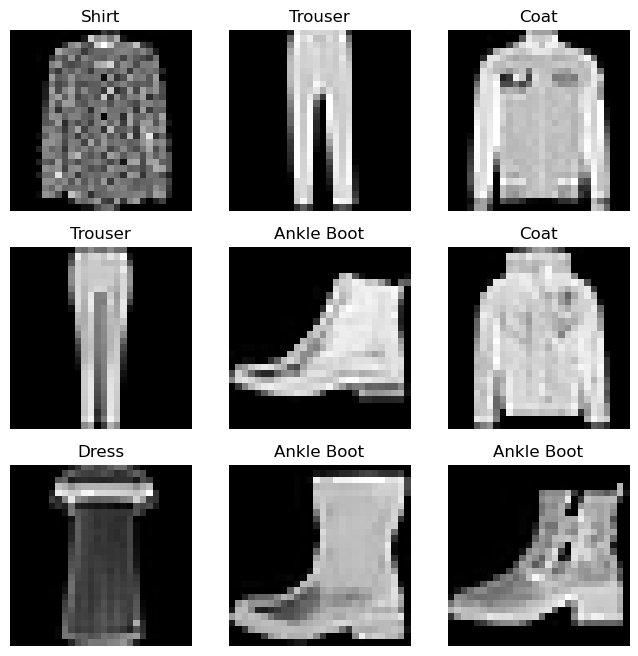

In [24]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()